 #  **Projet Final**

**Abdennacer Badaoui**

In [3]:
#importation des librairies

import matplotlib
import matplotlib.pyplot
import numpy
import math
from random import *
import os
import scipy.io
import scipy.linalg
import scipy.sparse
import scipy.sparse.linalg
from scipy.sparse.linalg import eigs
import sys
import solutions
import zsolutions4students

##       **Control of acoustic wave by changing the geometry on a surface**


Consider a domain Ω = [0, 1] × [0, 1], ∂Ω = Γd ∪ Γn, where Γd the left boundary. The Helmholtz
equation with Dirichlet boundary condition is considered

                                         △u + k^2 u = f, in Ω

                                            u = 0, on Γd

                                          ∂u/∂n = 0, on Γn

Question 1 :

From a given mesh, composed of triangles, modify the domain Ω, by removing some elements and
some nodes as explained during the lectures, to obtain a geometry with a part of the boundary 
which contains some irregularities.

In [4]:
#Pour ce faire, je vais definir d'abord un ensemble de fontions intermédiares

# Cette focntion retourne la liste des coordonnées qui compose la barriére délimité par les points (x1,y1) et (x2,y2) avec une fractale

def compute_barycenter_of_element(node_coords, p_elem2nodes, elem2nodes):
    spacedim = node_coords.shape[1]
    nelems = p_elem2nodes.shape[0]-1
    elem_coords = numpy.zeros((nelems, spacedim), dtype=numpy.float64)
    for i in range(0, nelems):
        nodes=elem2nodes[p_elem2nodes[i]:p_elem2nodes[i+1]]
        elem_coords[i,:]=numpy.average(node_coords[nodes,:], axis=0)
    return elem_coords

def remove_node_to_mesh(node_coords, p_elem2nodes, elem2nodes, nodeid):
    n=p_elem2nodes[1] # n=3 pour des maillages triangulaires , n=4 pour des maillages quadrilatéres
    
    node_coords = numpy.delete(node_coords, nodeid, 0)
    
    L=[]
    elem2nodes_list= elem2nodes.tolist() 
    
    for i in range(0,len(elem2nodes_list),n):
        L.append(elem2nodes_list[i:i+n]) # liste L qui contient des listes chacun represeantant un element
    
    M=[]
    for i in range(len(L)):
        if nodeid in L[i]:
            for k in range(n):
                M.append(i*n+k) # M liste qui contient les ids des élement à supprimer
                   
    elem2nodes = numpy.delete(elem2nodes, M)
               
    for i in range(0,elem2nodes.size):
        if elem2nodes[i]>nodeid:
            elem2nodes[i]=elem2nodes[i]-1 # actualiser les ids des noeuds
        
    
    return node_coords, p_elem2nodes, elem2nodes

def remove_elem_to_mesh(node_coords, p_elem2nodes, elem2nodes, elemid):
    n=p_elem2nodes[1]
    #les id des noeuds qui compose l'element elemid
    indices=[n*elemid+k for k in range(n)]
    nodes_of_element=[elem2nodes[i] for i in indices]
    #Supprision de la suite des noueds qui compose l'element 
    elem2nodes = numpy.delete(elem2nodes, [n*elemid+k for k in range(n)]) 
    p_elem2nodes=p_elem2nodes[:-1]
    
    # supprision des noeuds qui restent libres sans elements
    M=[]
    for i in nodes_of_element:
        if i not in elem2nodes:
            M.append(i)
    # Décalage des id des noeuds à supprimer         
    for i in range(len(M)):
        for j in range(i+1,len(M)):
            if M[j]>M[i]:
                M[j]=M[j]-1
    # Supprision
    for i in M:
        node_coords, p_elem2nodes, elem2nodes=remove_node_to_mesh(node_coords, p_elem2nodes, elem2nodes, i)
                
    return node_coords, p_elem2nodes, elem2nodes


def fractal_coords(x1,y1,x2,y2,n):
    global L # L est la liste qui va recupere les coordonnées 
    if n==0:
        
        L.append([x2,y2,0.0])
        return 
    dist = ((x2-x1)**2+(y2-y1)**2)**0.5
    direction = math.atan2(y2-y1,x2-x1)
    px1, py1 = x1+dist/4*math.cos(direction), y1+dist/4*math.sin(direction)
    px2, py2 = px1+dist/4*math.cos(direction+math.radians(90)), py1+dist/4*math.sin(direction+math.radians(90))
    px3, py3 = px2+dist/4*math.cos(direction), py2+dist/4*math.sin(direction)
    px4, py4 = px3+dist/4*math.cos(direction-math.radians(90)), py3+dist/4*math.sin(direction-math.radians(90))
    px5, py5 = px4+dist/4*math.cos(direction-math.radians(90)), py4+dist/4*math.sin(direction-math.radians(90))
    px6, py6 = px5+dist/4*math.cos(direction), py5+dist/4*math.sin(direction)
    px7, py7 = x1+3*dist/4*math.cos(direction), y1+3*dist/4*math.sin(direction)
    
    fractal_coords(x1,y1,px1,py1,n-1)
    fractal_coords(px1,py1,px2,py2,n-1)
    fractal_coords(px2,py2,px3,py3,n-1)
    fractal_coords(px3,py3,px4,py4,n-1)
    fractal_coords(px4,py4,px5,py5,n-1)
    fractal_coords(px5,py5,px6,py6,n-1)
    fractal_coords(px6,py6,px7,py7,n-1)
    fractal_coords(px7,py7,x2,y2,n-1)
    



INT_MAX = 10000

# fonction qui retourne True si le point q apparteint au segment pr, False sinon
def on_Segment(p, q, r):

    if ((q[0] <= max(p[0], r[0])) & (q[0] >= min(p[0], r[0])) & (q[1] <= max(p[1], r[1])) & (q[1] >= min(p[1], r[1]))):
        return True
    return False

#Fonction qui retourne :
# 0 si p,q et r sont colinéaires
# 1 si p,q et r sont dans le sens des aiguilles d'une montre
# 2 si p,q et r sont dans le sens antihoraire
def orientation(p, q, r):

    valeur = (((q[1] - p[1]) *(r[0] - q[0])) -((q[0] - p[0]) *(r[1] - q[1])))
    if valeur == 0:
        return 0
    if valeur > 0:
        return 1 
    else:
        return 2
    
def do_intersect(p1, q1, p2, q2):

   # Trouver les quatre orientations nécessaires pour les cas généraux et spéciaux
    z1 = orientation(p1, q1, p2)
    z2 = orientation(p1, q1, q2)
    z3 = orientation(p2, q2, p1)
    z4 = orientation(p2, q2, q1)

    if (z1 != z2) and (z3 != z4): # le cas général
        return True
    
    # Cas particuliers
    # p1, q1 et p2 sont colinéaires et
    # p2 se trouve sur le segment p1q1
    if (z1 == 0) and (on_Segment(p1, p2, q1)):
        return True
    
    # p1, q1 et p2 sont colinéaires et
    # q2 se trouve sur le segment p1q1
    if (z2 == 0) and (on_Segment(p1, q2, q1)):
        return True
    
    # p2, q2 et p1 sont colinéaires et
    # p1 se trouve sur le segment p2q2
    if (z3 == 0) and (on_Segment(p2, p1, q2)):
        return True
    
    # p2, q2 et q1 sont colinéaires et
    # q1 se trouve sur le segment p2q2
    if (z4 == 0) and (on_Segment(p2, q1, q2)):
        return True
    return False

# Fonction qui retourne True si point "p" est dans un polygone "points", False sinon
def is_inside_polygon(points, p):

    n = len(points)
    # Il doit y avoir au moins 3 sommets dans le polygone
    if n < 3:
        return False

    # Créer un point pour le segment de droite de p à l'infini
    infini = (INT_MAX, p[1])
    
    # Compter le nombre de points du polygone dont la coordonnée y est égale à la coordonnée y du point.
    decrease = 0
    ct = i = 0
    
    while True:
        next = (i + 1) % n

        if(points[i][1] == p[1]):
            decrease += 1

        # Vérifier si le segment de ligne de 'p' à 'infini' coupe le segment de ligne de 'polygone[i]' à 'polygone[next]'.
        if (do_intersect(points[i],points[next],p, infini)):
            # Si le point 'p' est colinéaire avec le segment de droite 'i-next', alors vérifiez s'il se trouve
            # sur le segment. Si c'est le cas, retournez true, sinon false
            if orientation(points[i], p,points[next]) == 0:
                return on_Segment(points[i], p,points[next])
            ct += 1

        i = next
        
        if (i == 0):
            break
    # Réduire le nombre de points en diminuant le nombre de points, car ces points auraient été ajoutés deux fois.
    ct -= decrease
    # Retourne True si le nombre est impair, False sinon.
    return (ct % 2 == 1)




<IPython.core.display.Javascript object>


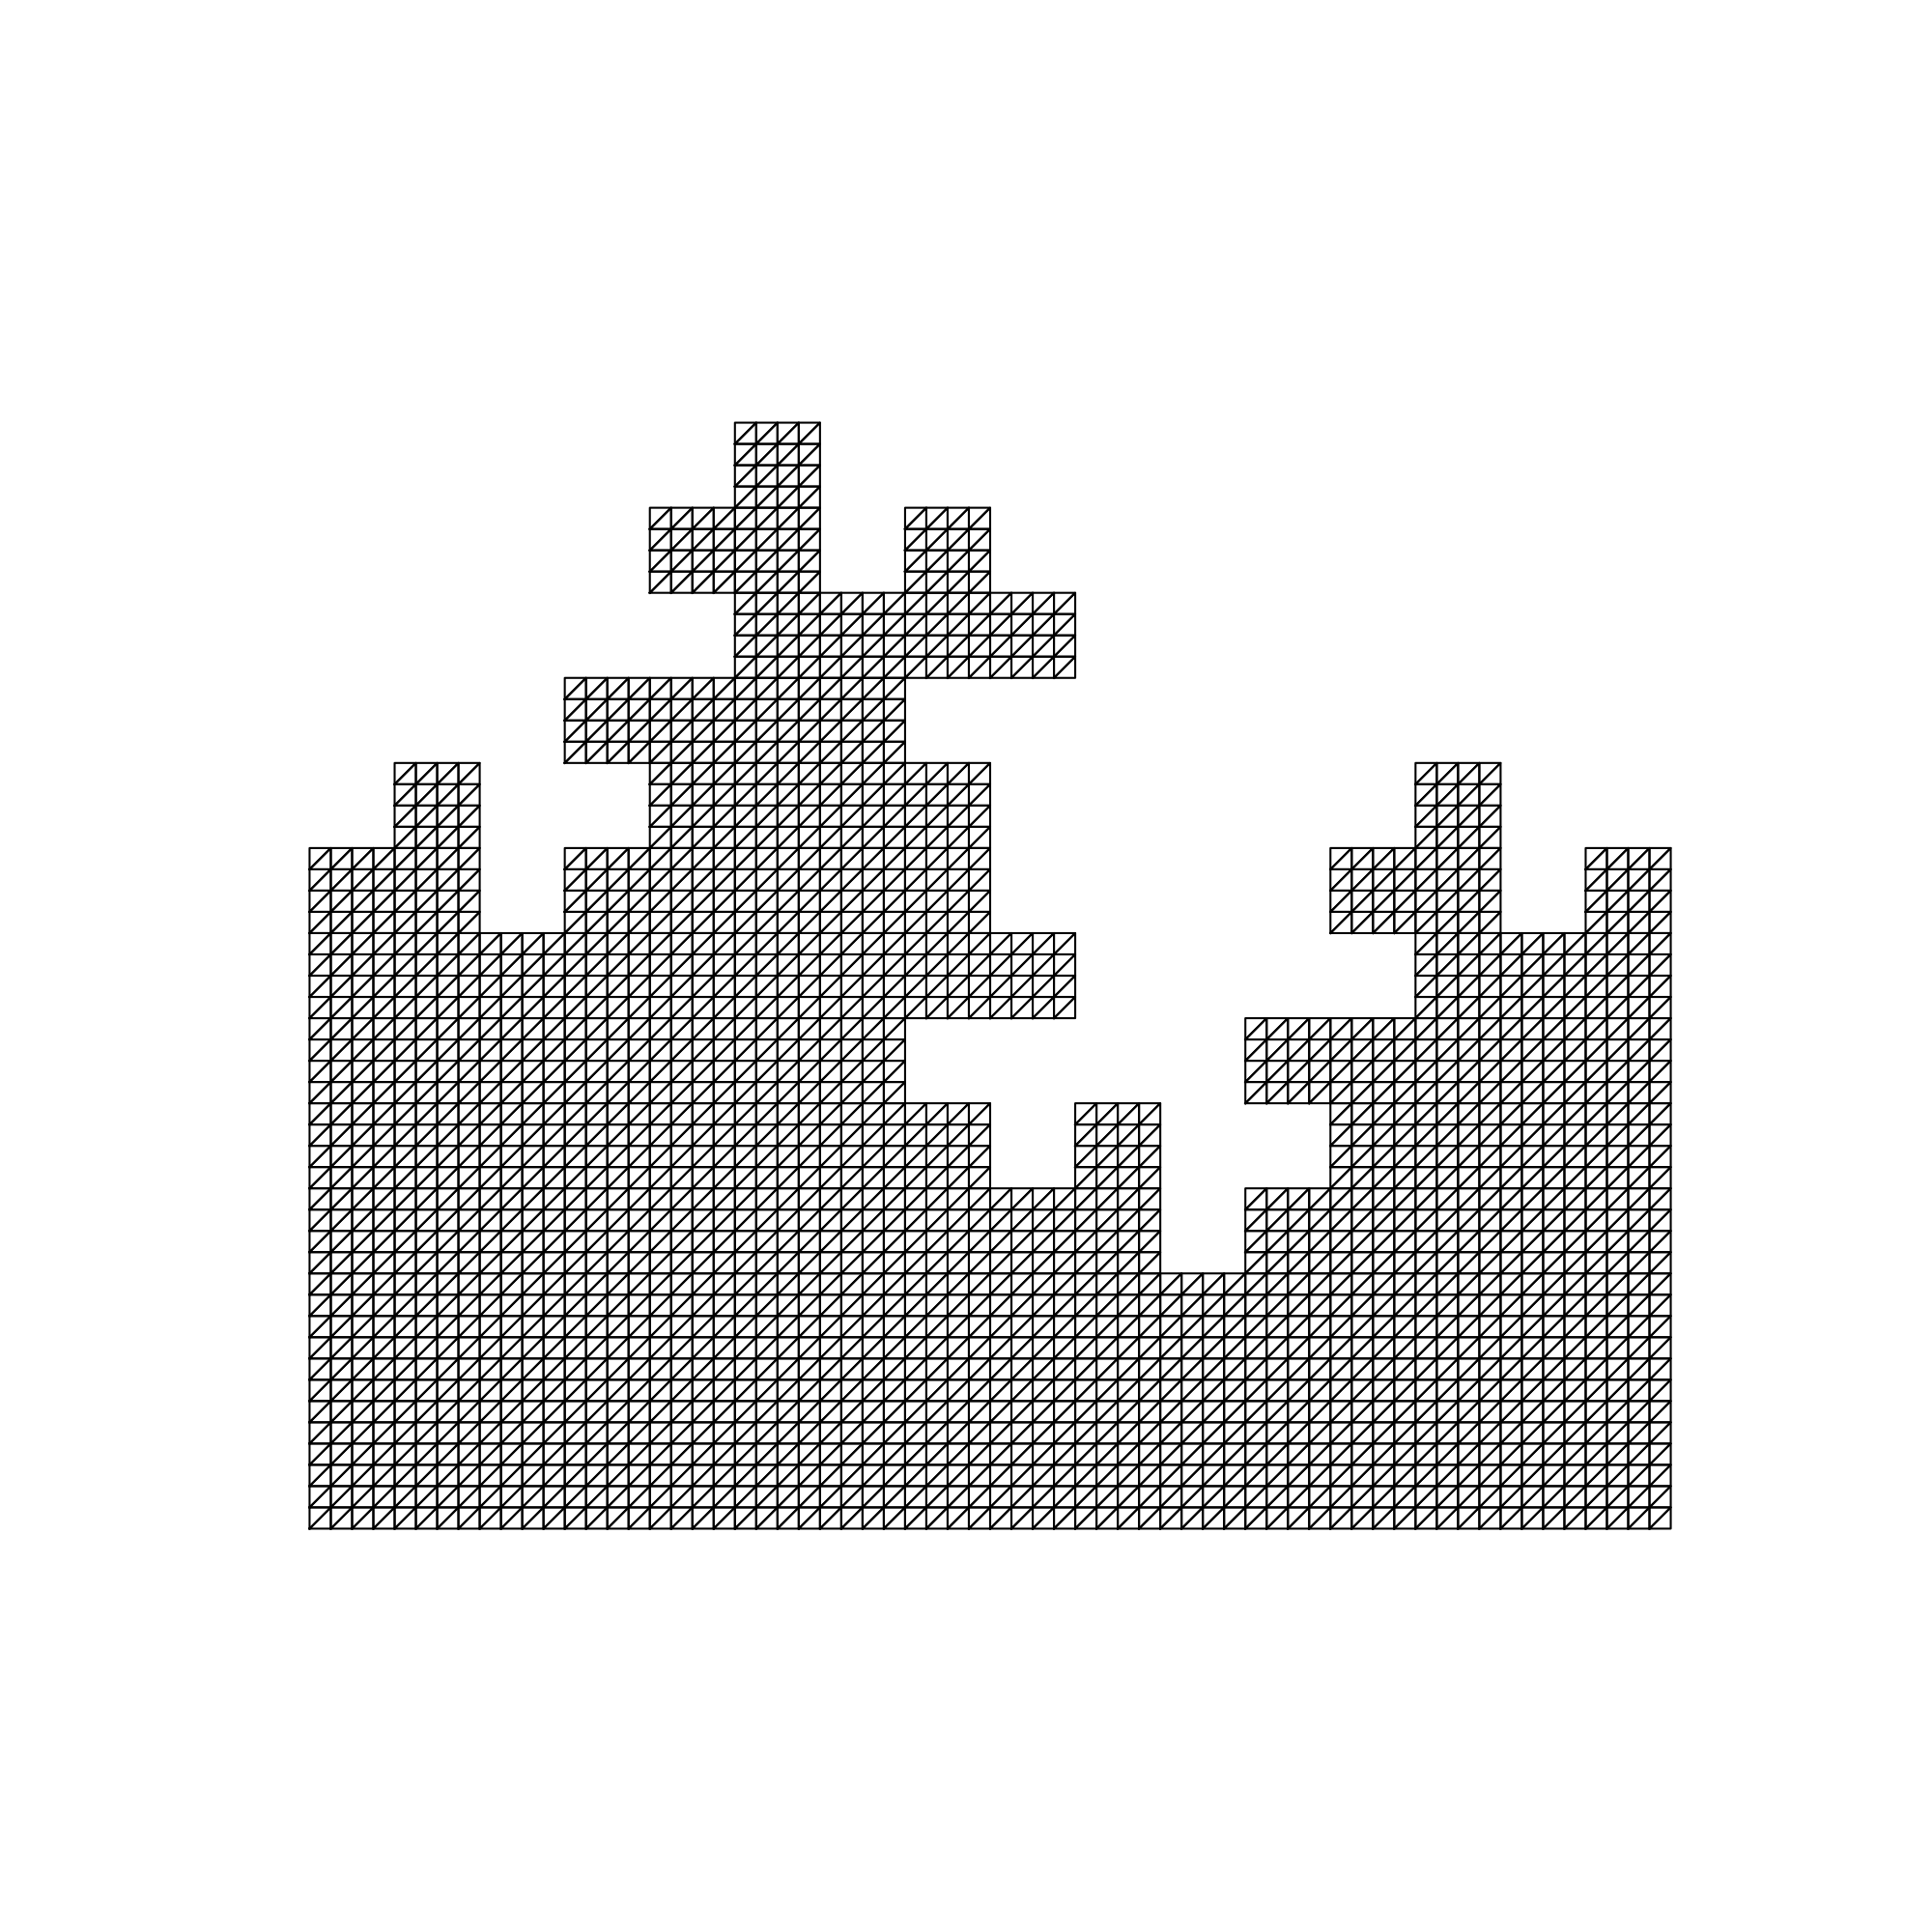

In [97]:
'''la fractale 2eme ordre'''

n=2 #l'ordre de la fractale

xmin, xmax, ymin, ymax = 0.0, 1.0, 0.0, 1.0
nelemsx, nelemsy = 64,64
nelems = nelemsx * nelemsy
nnodes = (nelemsx + 1) * (nelemsy + 1)
node_coords, node_l2g, p_elem2nodes, elem2nodes = solutions._set_trimesh(xmin, xmax, ymin, ymax, nelemsx, nelemsy)
nodes_on_boundary = solutions._set_trimesh_boundary(nelemsx, nelemsy)

L=[[0.0,ymax,0.0],[0.0,0.5,0.0]]
fractal_coords(0,0.5,xmax,0.5,n)
L.append([xmax,ymax,0.0])


bary = compute_barycenter_of_element(node_coords, p_elem2nodes, elem2nodes)
polygone=L

# Supprimer les élements de la maillage dont le barycentre est dans le polygone
ct=-1
for point in bary:
    ct+=1
    if is_inside_polygon(polygone, point):
        numpy.delete(bary,ct)
        node_coords, p_elem2nodes, elem2nodes = remove_elem_to_mesh(node_coords, p_elem2nodes, elem2nodes, ct)
        ct=ct-1 # décalage des indices aprés la supprision
        
fig = matplotlib.pyplot.figure(figsize=(20,20))
ax = matplotlib.pyplot.subplot(1, 1, 1)
ax.set_aspect('equal')
ax.axis('off')
solutions._plot_mesh(p_elem2nodes, elem2nodes, node_coords, color='black')


Question 2 :
Solve the Helmholtz equation in this geometry for different frequencies. What do you observe ?


In [6]:
def _plot_contourf(nelems, p_elem2nodes, elem2nodes, node_coords, node_data, **kwargs):
    """Plot node data parameter on the mesh.
    """
    x = node_coords[:, 0]
    y = node_coords[:, 1]
    z = node_data

    # create triangles for triangulation
    triangles = []
    # print(nelems)
    for i in range(nelems):
        cs = p_elem2nodes[i]
        ce = p_elem2nodes[i + 1]
        triangles.append(elem2nodes[cs:ce])
        # print(triangles[i])
        #triangles[i,:] = elem2nodes[cs:ce].tolist()

    # creates triangulation
    triang = matplotlib.tri.Triangulation(x, y, triangles)
    fig = matplotlib.pyplot.figure()
    axs = fig.add_subplot(projection='3d')
    axs.scatter(x, y, z, c=z, cmap='viridis')
    axs.plot_trisurf(x, y, z, cmap='viridis', edgecolor='none');
    matplotlib.pyplot.show()

    return

In [98]:
# Python packages
import matplotlib.pyplot
import matplotlib.pylab
from mpl_toolkits.mplot3d import Axes3D
import numpy
import os
import scipy.io
import scipy.linalg
import scipy.sparse
import scipy.sparse.linalg
import sys

%matplotlib notebook

# MRG packages
import zsolutions4students

Bo=numpy.asanyarray([i for i in range(nelemsx + 1)])

def simulation(p_elem2nodes, elem2nodes, node_coords,wavenumber_divided_by_pi,f,plot):
    global Bo

    nnodes = node_coords.shape[0]
    nelems = len(p_elem2nodes)-1
    wavenumber=wavenumber_divided_by_pi*numpy.pi

    # -- plot mesh
    '''
    fig = matplotlib.pyplot.figure(1)
    ax = matplotlib.pyplot.subplot(1, 1, 1)
    ax.set_aspect('equal')
    ax.axis('off')
    solutions._plot_mesh(p_elem2nodes, elem2nodes, node_coords, color='orange')
    matplotlib.pyplot.show()
    '''

    # -- set boundary geometry
    # boundary composed of nodes
    nodes_on_boundary=Bo

    # -- set exact solution
    solexact = numpy.zeros((len(nodes_on_boundary.tolist()), 1), dtype=numpy.complex128)
    laplacian_of_solexact = numpy.zeros((nnodes, 1), dtype=numpy.complex128)
    for i in range(len(nodes_on_boundary.tolist())):
        solexact[i] = 0

    # -- set dirichlet boundary conditions
    values_at_nodes_on_boundary = numpy.zeros((nnodes, 1), dtype=numpy.complex128)
    values_at_nodes_on_boundary[nodes_on_boundary] = solexact[nodes_on_boundary]

    # -- set finite element matrices and right hand side
    f_unassembled = numpy.zeros((nnodes, 1), dtype=numpy.complex128)

    for i in range(nnodes):
        f_unassembled[i] = f

    coef_k = numpy.ones((nelems, 1), dtype=numpy.complex128)
    coef_m = numpy.ones((nelems, 1), dtype=numpy.complex128)
    K, M, F = zsolutions4students._set_fem_assembly(p_elem2nodes, elem2nodes, node_coords, f_unassembled, coef_k, coef_m)
    A = K - wavenumber**2 * M
    B = F

    # -- apply Dirichlet boundary conditions
    A, B = zsolutions4students._set_dirichlet_condition(nodes_on_boundary, values_at_nodes_on_boundary, A, B)

    # -- solve linear system
    sol = scipy.linalg.solve(A, B)

    # -- plot finite element solution
    solreal = sol.reshape((sol.shape[0], ))
    if plot:
        print('solreal for k =', wavenumber_divided_by_pi,'π')
        _ =_plot_contourf(nelems, p_elem2nodes, elem2nodes, node_coords, numpy.real(solreal))
    
    #print('solimag')
    #_ = _plot_contourf(nelems, p_elem2nodes, elem2nodes, node_coords, numpy.imag(solreal))
    
    return A, B, sol

print('conditionnnement de la matrice A :',numpy.linalg.cond(A))

conditionnnement de la matrice A : 22751.312850802424


solreal for k = 1 π


<IPython.core.display.Javascript object>


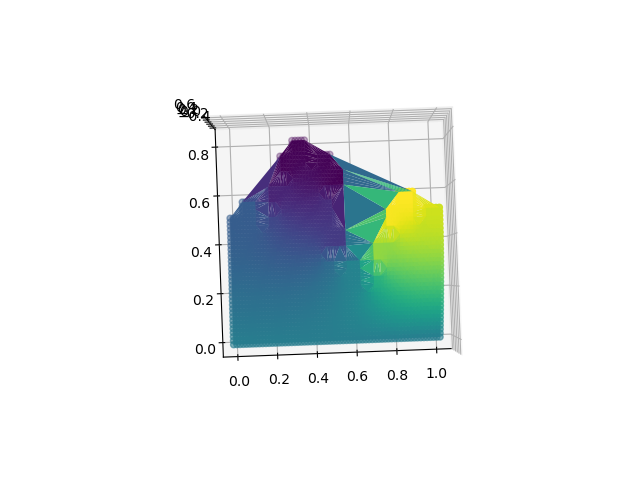

solreal for k = 2 π


<IPython.core.display.Javascript object>


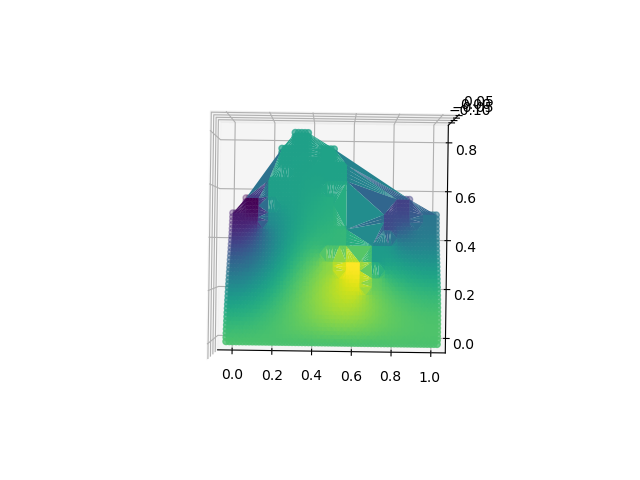

solreal for k = 3 π


<IPython.core.display.Javascript object>


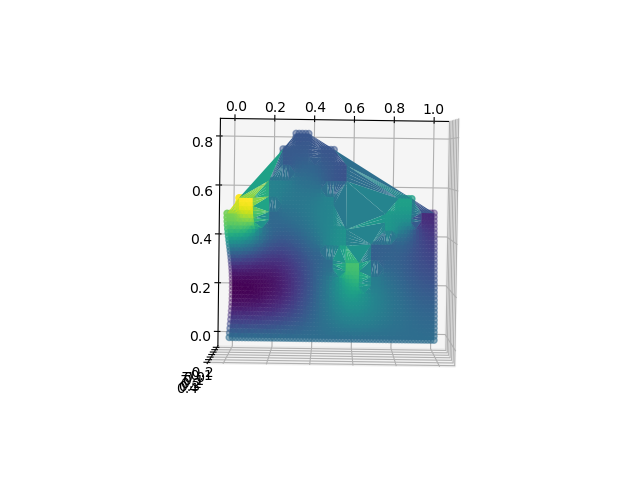

solreal for k = 4 π


<IPython.core.display.Javascript object>


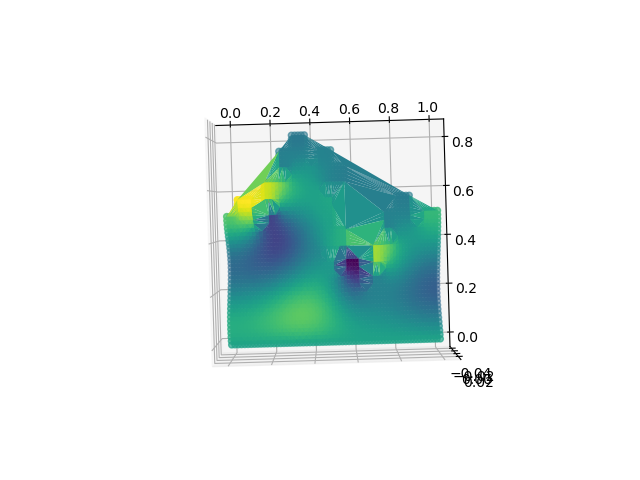

solreal for k = 5 π


<IPython.core.display.Javascript object>


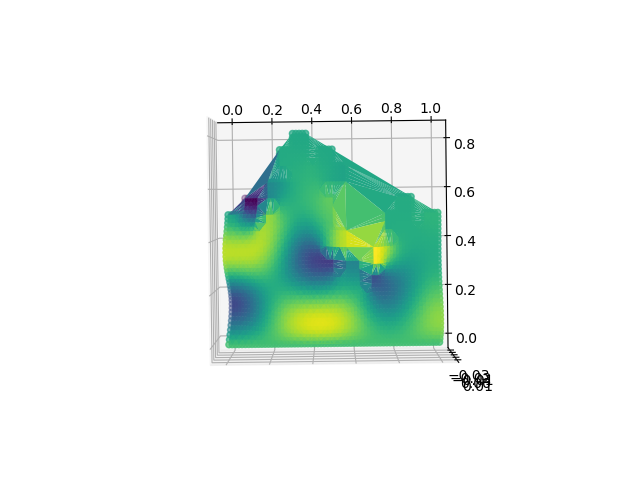

solreal for k = 6 π


<IPython.core.display.Javascript object>


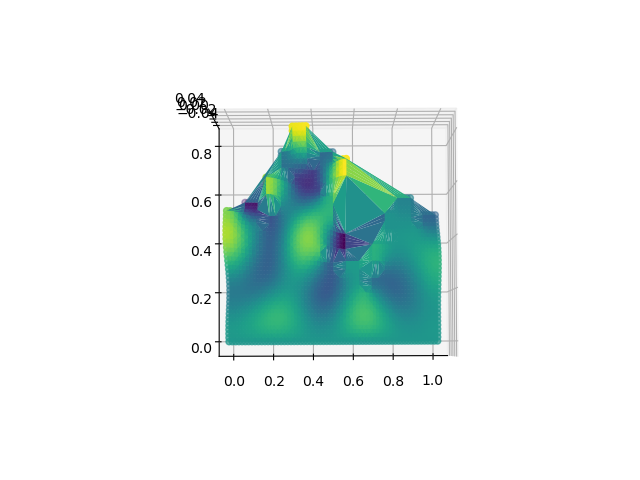

solreal for k = 7 π


<IPython.core.display.Javascript object>


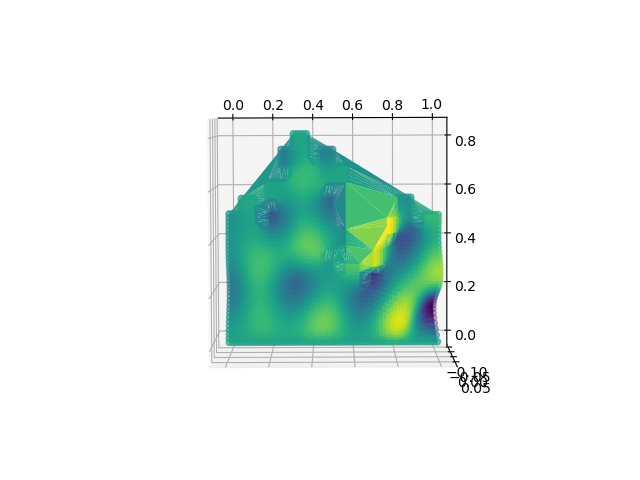

solreal for k = 8 π


<IPython.core.display.Javascript object>


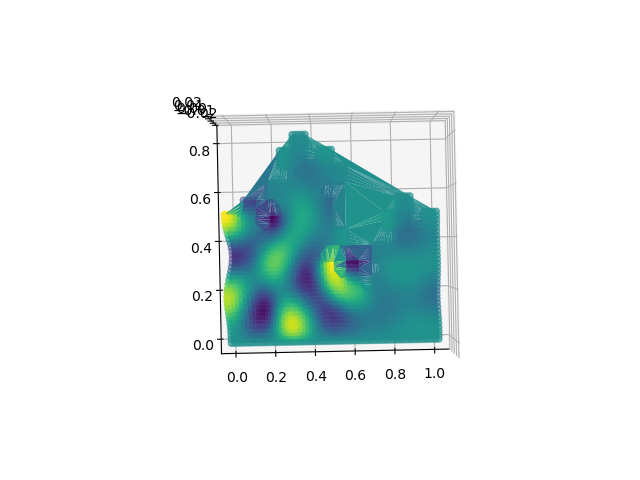

solreal for k = 9 π


<IPython.core.display.Javascript object>


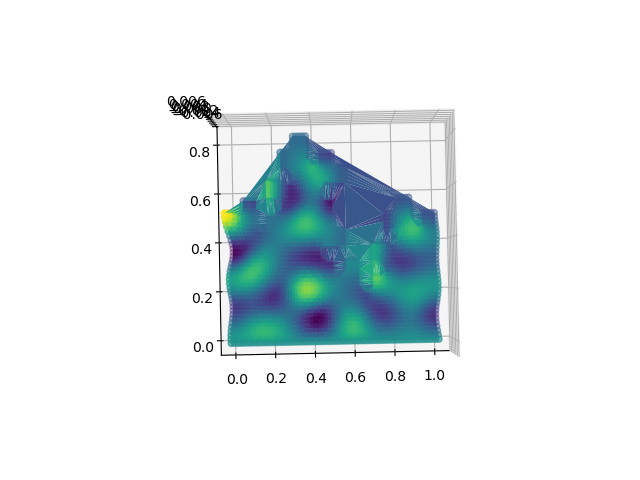

solreal for k = 10 π


<IPython.core.display.Javascript object>


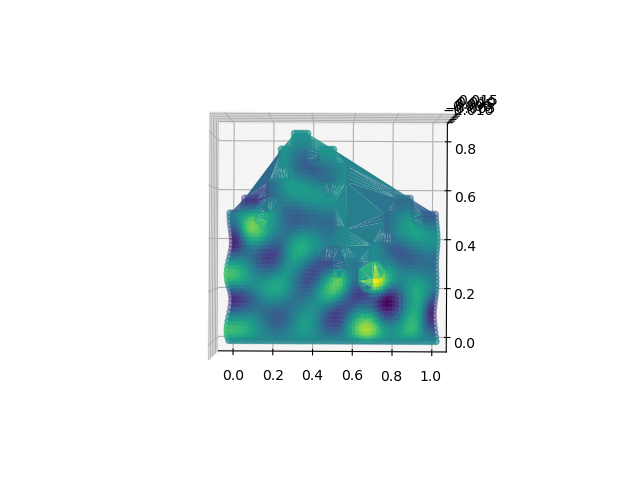

End.


In [30]:
# Simulations pour differentes valeurs de k
k_set_divided_by_pi=[i for i in range(1,11)]

for i in k_set_divided_by_pi:
    simulation(p_elem2nodes, elem2nodes, node_coords, i, 1, True)
print('End.')    

Question 3 :
Determine the eigenvalues of the Helmholtz equation in this geometry and determine (if you can,
by using the existence surface and energy losses quantity, if not, by visualizing), the eigenmodes
localizing inside and outside this geometry. What do you observe ?

In [99]:
'''Les valeurs propres '''

# On prend k=3π, f=1
A, B, sol=simulation(p_elem2nodes, elem2nodes, node_coords, 3, 1, False)
#Les valeurs propres de la matrice de Helmtholtz
vals, vecs = numpy.linalg.eig(A)
print('Eigenvalues :',vals.tolist())



Eigenvalues : [(-0.018040547257260037+0j), (-0.00016048650300080084+0j), (7.9730495325081465+0j), (7.953322634950701+0j), (7.950155883378507+0j), (7.9466618866686325+0j), (7.929462314150125+0j), (7.923845474038165+0j), (7.916541087903469+0j), (7.902567164274753+0j), (7.895690496936823+0j), (7.886467105673218+0j), (7.881059109927809+0j), (7.864916552922389+0j), (7.858642209054558+0j), (7.8545772208736695+0j), (7.846595037198264+0j), (7.837980079651678+0j), (7.829905362191258+0j), (7.823666002783706+0j), (7.817721803122223+0j), (7.80625402479832+0j), (7.7932405838634535+0j), (7.786681050516036+0j), (7.785783622812814+0j), (7.778497643304649+0j), (7.770607204090106+0j), (7.761320629101577+0j), (7.755139900840348+0j), (7.74422233164205+0j), (7.737861203465107+0j), (7.732735659274945+0j), (7.722836205715432+0j), (7.71124672957771+0j), (7.703729790532623+0j), (7.705847272541479+0j), (7.691599513091835+0j), (7.680612243934459+0j), (7.681707994516774+0j), (7.666303780953627+0j), (7.66542509580

<IPython.core.display.Javascript object>


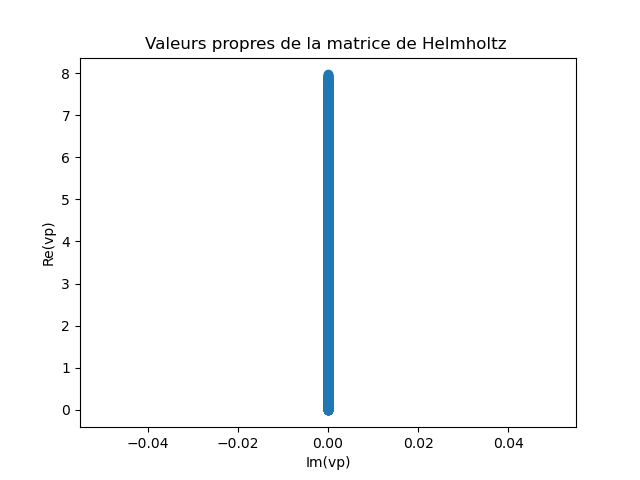

In [75]:
# Les valeurs propres dans le plan complexe

x = [ele.real for ele in vals]
# extract imaginary part
y = [ele.imag for ele in vals]
  
# plot the complex numbers
matplotlib.pyplot.scatter(y, x, marker='o')
matplotlib.pyplot.ylabel('Re(vp)')

matplotlib.pyplot.xlabel('Im(vp)')
matplotlib.pyplot.title('Valeurs propres de la matrice de Helmholtz ')
matplotlib.pyplot.show()

In [100]:
'''Surface d'existence'''
# Les vecteurs propres données par np.linalg.eig sont bien normales

def existence_surface(vecs):
    S=[]
    for i in range(len(A)):
        vecs_square = [abs(elem)**2 for elem in vecs[:,i]]
        S_i = 1 / (( numpy.linalg.norm(vecs_square))**2)
        S.append((S_i,i))
        S_sorted= sorted(S, key=lambda tup: tup[0])
    return S_sorted 




In [77]:
existence_surface(vecs)

[(1.0, 2176),
 (1.0, 2177),
 (1.0, 2178),
 (1.0, 2179),
 (1.0, 2180),
 (1.0, 2181),
 (1.0, 2182),
 (1.0, 2183),
 (1.0, 2184),
 (1.0, 2185),
 (1.0, 2186),
 (1.0, 2187),
 (1.0, 2188),
 (1.0, 2189),
 (1.0, 2190),
 (1.0, 2191),
 (1.0, 2192),
 (1.0, 2193),
 (1.0, 2194),
 (1.0, 2195),
 (1.0, 2196),
 (1.0, 2197),
 (1.0, 2198),
 (1.0, 2199),
 (1.0, 2200),
 (1.0, 2201),
 (1.0, 2202),
 (1.0, 2203),
 (1.0, 2204),
 (1.0, 2205),
 (1.0, 2206),
 (1.0, 2207),
 (1.0, 2208),
 (1.0, 2209),
 (1.0, 2210),
 (1.0, 2211),
 (1.0, 2212),
 (1.0, 2213),
 (1.0, 2214),
 (1.0, 2215),
 (1.0, 2216),
 (1.0, 2217),
 (1.0, 2218),
 (1.0, 2219),
 (1.0, 2220),
 (1.0, 2221),
 (1.0, 2222),
 (1.0, 2223),
 (1.0, 2224),
 (1.0, 2225),
 (1.0, 2226),
 (1.0, 2227),
 (1.0, 2228),
 (1.0, 2229),
 (1.0, 2230),
 (1.0, 2231),
 (1.0, 2232),
 (1.0, 2233),
 (1.0, 2234),
 (1.0, 2235),
 (1.0, 2236),
 (1.0, 2237),
 (1.0, 2238),
 (1.0, 2239),
 (1.0, 2240),
 (9.605109668702369, 1607),
 (10.446540860828566, 1623),
 (16.500367777345897, 335),
 (17.

<IPython.core.display.Javascript object>


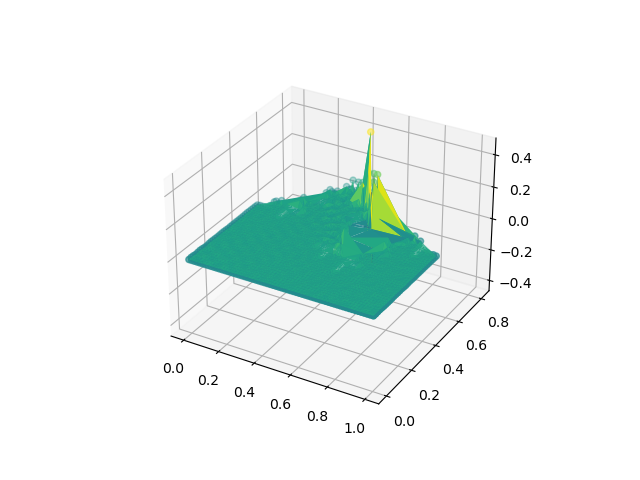

In [107]:
#Visualization des eigenmodes
vec = vecs[:,1607]

solreal = vec.reshape((vec.shape[0], ))

_ =_plot_contourf(nelems, p_elem2nodes, elem2nodes, node_coords, numpy.real(solreal))

Question 4 : Repeat the previous questions for a geometry with a part of the boundary 
which contains multilevels irregularities (like prefractals). What do you observe ?

<IPython.core.display.Javascript object>


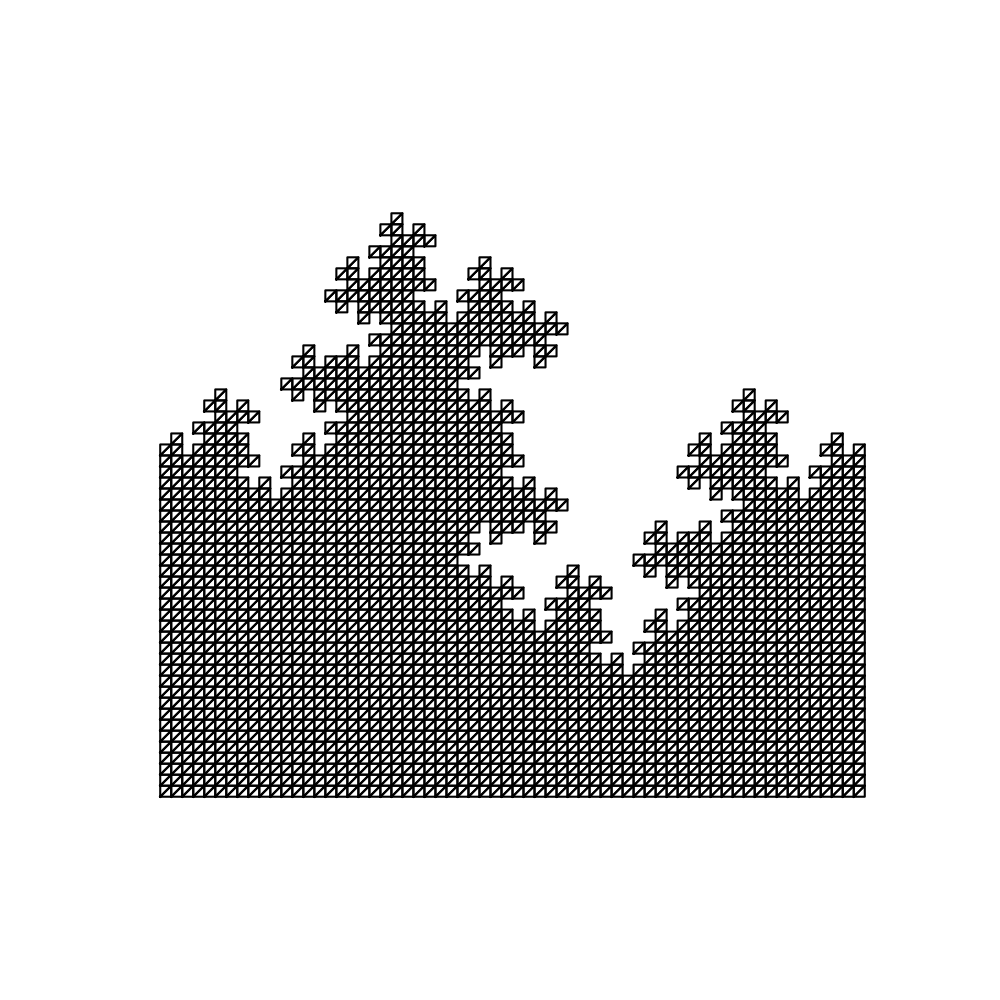

In [84]:
'''la fractale 3eme ordre'''

n=3 #l'ordre de la fractale

xmin, xmax, ymin, ymax = 0.0, 1.0, 0.0, 1.0
nelemsx, nelemsy = 64,64
nelems = nelemsx * nelemsy
nnodes = (nelemsx + 1) * (nelemsy + 1)
node_coords, node_l2g, p_elem2nodes, elem2nodes = solutions._set_trimesh(xmin, xmax, ymin, ymax, nelemsx, nelemsy)
nodes_on_boundary = solutions._set_trimesh_boundary(nelemsx, nelemsy)

L=[[0.0,ymax,0.0],[0.0,0.5,0.0]]
fractal_coords(0,0.5,xmax,0.5,n)
L.append([xmax,ymax,0.0])


bary = compute_barycenter_of_element(node_coords, p_elem2nodes, elem2nodes)
polygone=L

# Supprimer les élements de la maillage dont le barycentre est dans le polygone
ct=-1
for point in bary:
    ct+=1
    if is_inside_polygon(polygone, point):
        numpy.delete(bary,ct)
        node_coords, p_elem2nodes, elem2nodes = remove_elem_to_mesh(node_coords, p_elem2nodes, elem2nodes, ct)
        ct=ct-1 # décalage des indices aprés la supprision
        
fig = matplotlib.pyplot.figure(figsize=(10,10))
ax = matplotlib.pyplot.subplot(1, 1, 1)
ax.set_aspect('equal')
ax.axis('off')
solutions._plot_mesh(p_elem2nodes, elem2nodes, node_coords, color='black')

solreal for k = 1 π


<IPython.core.display.Javascript object>


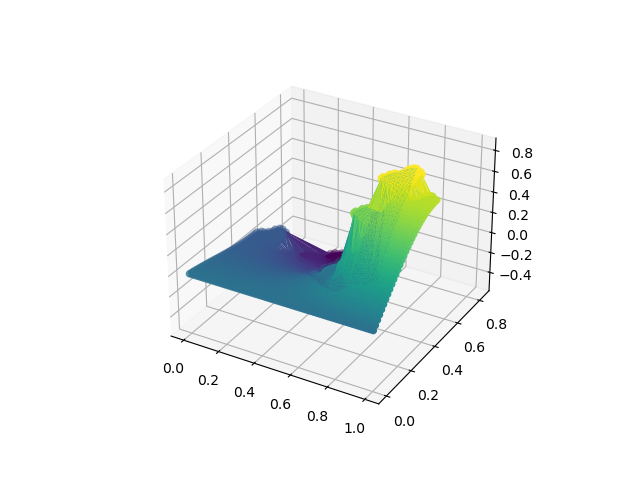

solreal for k = 2 π


<IPython.core.display.Javascript object>


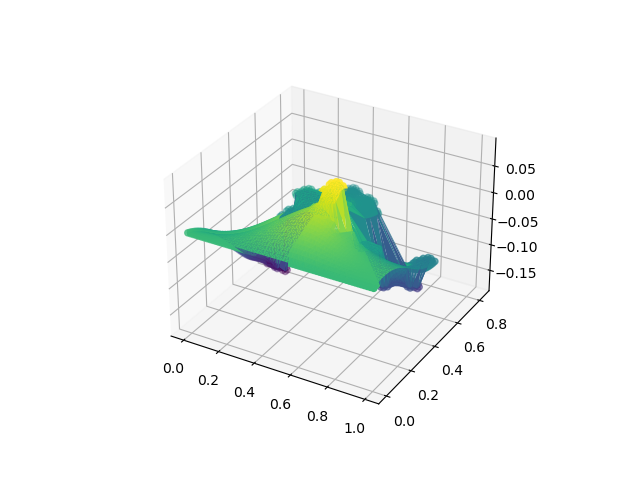

solreal for k = 3 π


<IPython.core.display.Javascript object>


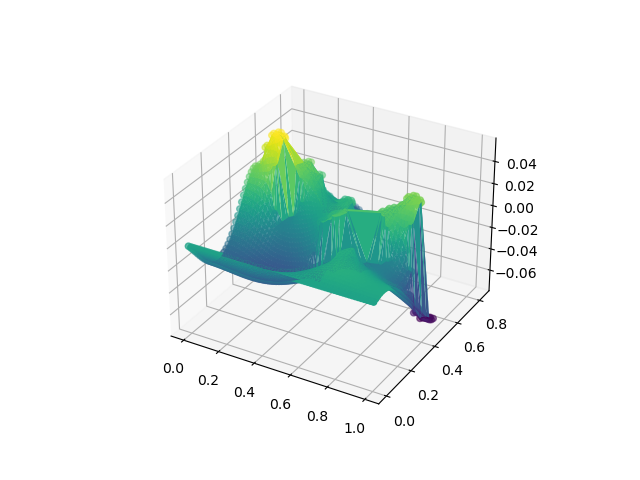

solreal for k = 4 π


<IPython.core.display.Javascript object>


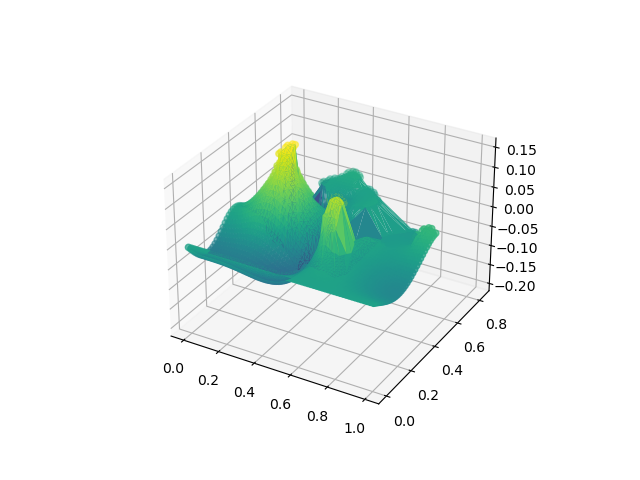

solreal for k = 5 π


<IPython.core.display.Javascript object>


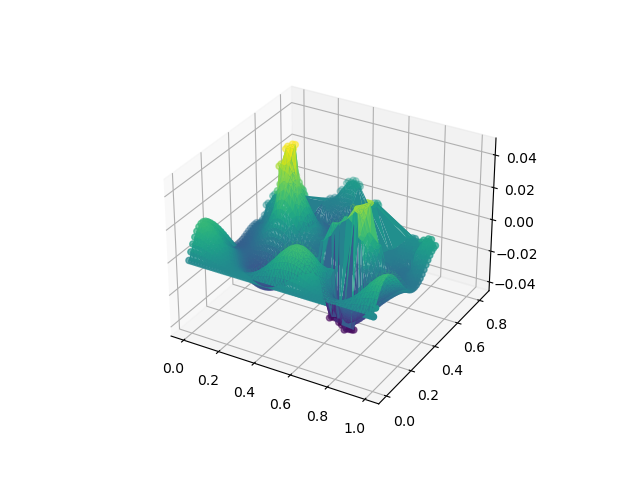

solreal for k = 6 π


<IPython.core.display.Javascript object>


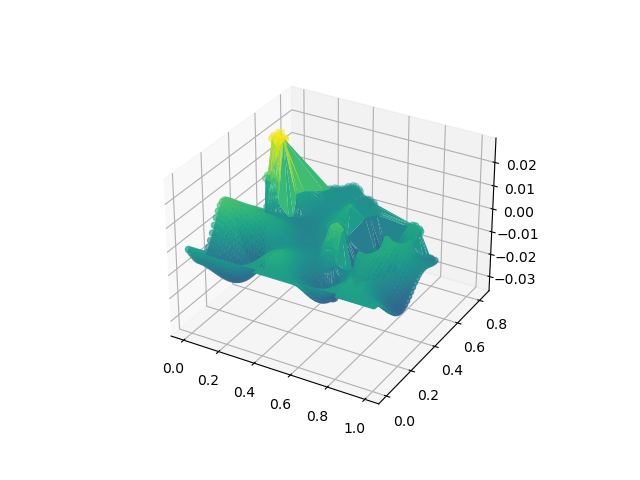

solreal for k = 7 π


<IPython.core.display.Javascript object>


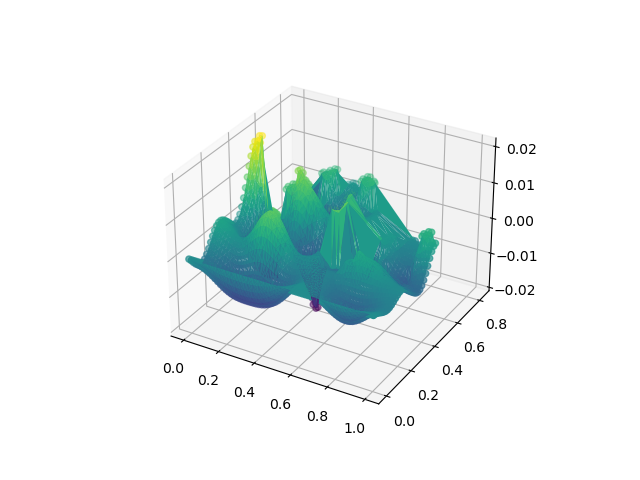

solreal for k = 8 π


<IPython.core.display.Javascript object>


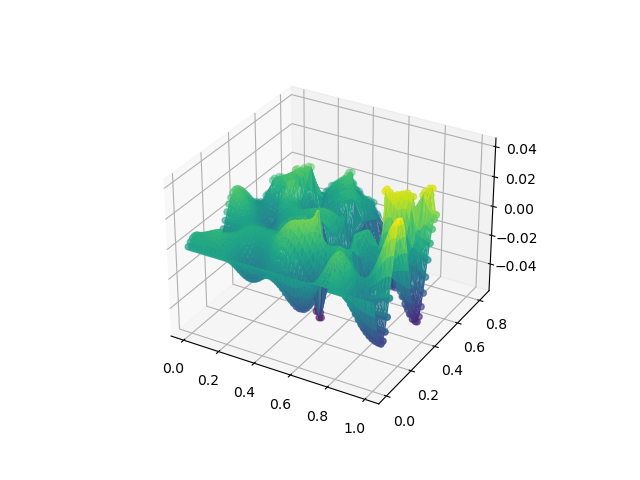

solreal for k = 9 π


<IPython.core.display.Javascript object>


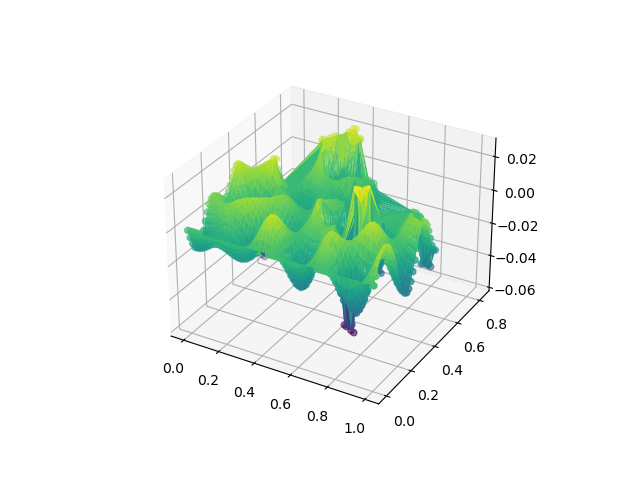

solreal for k = 10 π


<IPython.core.display.Javascript object>


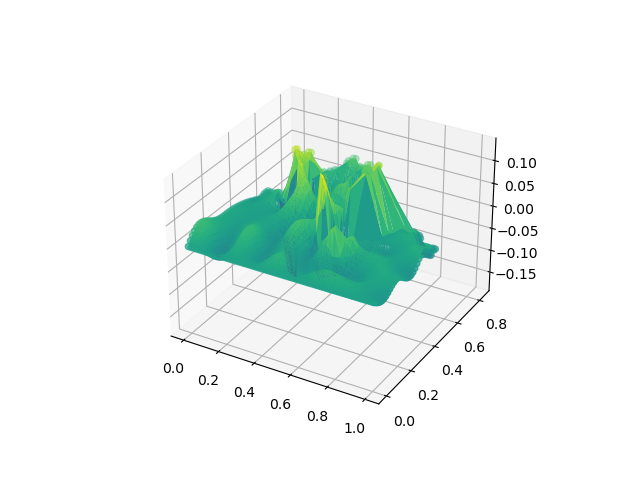

End.


In [62]:
k_set_divided_by_pi=[i for i in range(1,11)]

for i in k_set_divided_by_pi:
    simulation(p_elem2nodes, elem2nodes, node_coords, i, 1, True)
print('End.') 

In [85]:
'''Les valeurs propres '''

# On prend k=6π, f=1
A, B, sol=simulation(p_elem2nodes, elem2nodes, node_coords, 6, 1, False)
#Les valeurs propres de la matrice de Helmtholtz
vals, vecs = numpy.linalg.eig(A)
print('Eigenvalues :',vals.tolist())

Eigenvalues : [(7.950736894728188+0j), (7.930118847539478+0j), (7.927300039058771+0j), (7.922876185150109+0j), (7.905706479340132+0j), (7.899377644342044+0j), (7.8925577164003045+0j), (7.878329432434481+0j), (7.871585840597316+0j), (7.861857314525205+0j), (7.856299556162808+0j), (7.840326145402174+0j), (7.831639023537078+0j), (7.827679051900656+0j), (7.8204493466053+0j), (7.810915346619911+0j), (7.801412654872492+0j), (7.796353491567868+0j), (7.789978780586696+0j), (7.778061491184889+0j), (7.76420060602527+0j), (7.757647996347211+0j), (7.75617557782607+0j), (7.7516213583027636+0j), (7.739960610589988+0j), (7.735481453467173+0j), (7.726420172394937+0j), (7.713916911780535+0j), (7.707795291515532+0j), (7.701925766209593+0j), (7.692235920560053+0j), (7.682611760853546+0j), (7.675197493300705+0j), (7.663662112597993+0j), (7.653863117938386+0j), (7.652092376511767+0j), (7.646700652156123+0j), (7.632394938411843+0j), (7.6295778978037845+0j), (7.626727369111025+0j), (7.618840584047564+0j), (7

In [86]:
'''Surface d'existenece '''
existence_surface(vecs)

[(1.0, 2304),
 (1.0, 2305),
 (1.0, 2306),
 (1.0, 2307),
 (1.0, 2308),
 (1.0, 2309),
 (1.0, 2310),
 (1.0, 2311),
 (1.0, 2312),
 (1.0, 2313),
 (1.0, 2314),
 (1.0, 2315),
 (1.0, 2316),
 (1.0, 2317),
 (1.0, 2318),
 (1.0, 2319),
 (1.0, 2320),
 (1.0, 2321),
 (1.0, 2322),
 (1.0, 2323),
 (1.0, 2324),
 (1.0, 2325),
 (1.0, 2326),
 (1.0, 2327),
 (1.0, 2328),
 (1.0, 2329),
 (1.0, 2330),
 (1.0, 2331),
 (1.0, 2332),
 (1.0, 2333),
 (1.0, 2334),
 (1.0, 2335),
 (1.0, 2336),
 (1.0, 2337),
 (1.0, 2338),
 (1.0, 2339),
 (1.0, 2340),
 (1.0, 2341),
 (1.0, 2342),
 (1.0, 2343),
 (1.0, 2344),
 (1.0, 2345),
 (1.0, 2346),
 (1.0, 2347),
 (1.0, 2348),
 (1.0, 2349),
 (1.0, 2350),
 (1.0, 2351),
 (1.0, 2352),
 (1.0, 2353),
 (1.0, 2354),
 (1.0, 2355),
 (1.0, 2356),
 (1.0, 2357),
 (1.0, 2358),
 (1.0, 2359),
 (1.0, 2360),
 (1.0, 2361),
 (1.0, 2362),
 (1.0, 2363),
 (1.0, 2364),
 (1.0, 2365),
 (1.0, 2366),
 (1.0, 2367),
 (1.0, 2368),
 (5.118997607493884, 614),
 (6.211446641991932, 1500),
 (6.393798953867464, 1513),
 (7.847

<IPython.core.display.Javascript object>


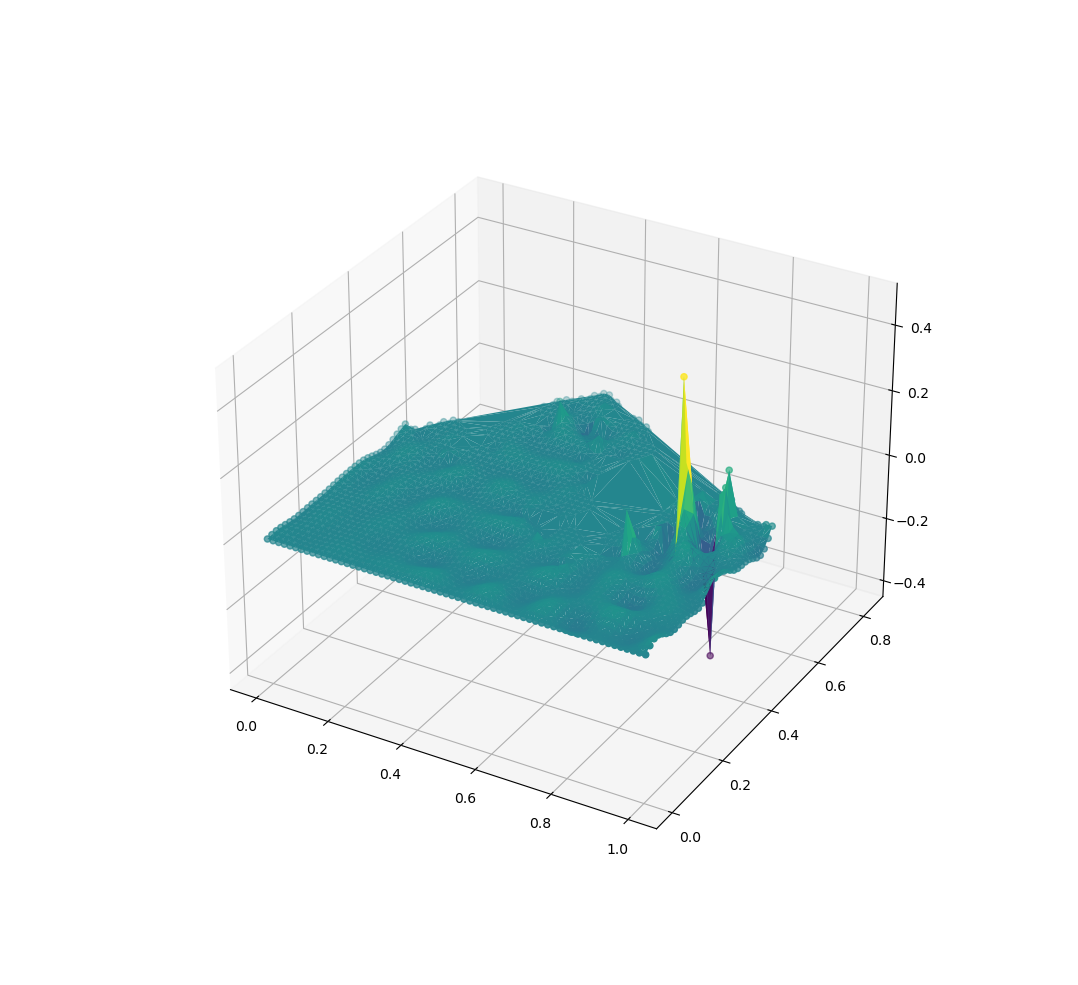

In [96]:
#Visualization des eigenmodes
vec = vecs[:,547]

solreal = vec.reshape((vec.shape[0], ))

_ =_plot_contourf(nelems, p_elem2nodes, elem2nodes, node_coords, numpy.real(solreal))

End.